In [1]:
# Code to import standard libraries

import sys
sys.path.append("../lib") # go to parent dir

import numpy as np
import scipy
import pandas as pd

import income.distributions as distributions
import income.utils as utils

%matplotlib inline
from IPython.display import HTML

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,4)
colors = ['r','g','b']

# Working with grouped income data

Grouped data are unavoidable if one wishes to study global income distributions. We face two sets of cases: in some cases, unit record data are unavailable even to the PovcalNet team (e.g. China); in (many) others, the PovcalNet team has unit record data but cannot share it widely - hence it cannot be the basis for an open visualisation tool. Moreover, PovcalNet automatically outputs grouped data (in Lorenz curve form) regardless of the original input data format (grouped or unit record). For this reason, we take grouped data as the lowest common denominator for distributional data.

Grouped data can take many forms, many of which are equivalent. In general, all members of the population or sample are listed in ascending order by income. Then, each record represents a contiguous range of these individuals (usually specified as a quantile range) along with a measure of the group's combined income (usually as the sum of their incomes, or their average income, or the sum of their incomes as a share of the population/sample total income). In the usual case, where these groups partition the entire sample/population, these measures may be cumulated.

Additionally, group thresholds may be reported, that is, the minimum and maximum income in each group.

Finally, additional statistics may be reported for the entire sample/population: the mean, median, minimum, maximum, sample/population size.

The example below generates a population of 150 lognormally distributed incomes, and calculates grouped income along with all of these measures. You will see that the Lorenz cuve ($L(p)$) arises naturally out of the cumulative group statistics.

In [2]:
# Code to generate sample lognormal data and generate groups

N = 150
quantile_partition = np.array([0.1,0.4,0.2,0.2,0.1]) # These are groups: e.g. bottom 20%, next 40%, ...

dist_example = distributions.LognormalIncomeDistribution(mean = 100, Gini=0.3)
observations = dist_example.generate(N = N)
observations.sort()

# A helper function to generate group statistics
def generate_stats(obs):
    return {
        'N':           len(obs),
        'Y_min':       np.min(obs),
        'Y_max':       np.max(obs),
        'Y_sum':       np.sum(obs),
        'Y_mean':      np.mean(obs)
    }
    
# Construct groups and generate stats
split_indices = (quantile_partition.cumsum()[:-1] * N + 0.5).astype(int)
groups = np.split(observations, split_indices)
stats = pd.DataFrame(generate_stats(g) for g in groups).round()

# Add stats that depend on totals (e.g. cumulative)
stats['cum_N'] = stats.N.cumsum()
stats['$p$'] = stats.cum_N / N
stats['cum_Y_sum'] = stats.Y_sum.cumsum()
stats['Y_p'] = (stats.Y_sum / np.sum(observations))
stats['cum_Y_p ($L$)'] = stats.Y_p.cumsum().round(2)
stats.Y_p = stats.Y_p.round(2)
stats['cum_Y_mean'] = (stats.cum_Y_sum / stats.cum_N).round()

# Reorder columns and output
stats[['N', 'cum_N', 'Y_min', 'Y_max', 'Y_mean', 'cum_Y_mean', 'Y_sum', 'cum_Y_sum', '$p$', 'Y_p', 'cum_Y_p ($L$)']]

,N,cum_N,Y_min,Y_max,Y_mean,cum_Y_mean,Y_sum,cum_Y_sum,$p$,Y_p,cum_Y_p ($L$)
0,15,15,26.0,46.0,37.0,37.0,549.0,549.0,0.1,0.03,0.03
1,60,75,46.0,95.0,69.0,63.0,4146.0,4695.0,0.5,0.25,0.29
2,30,105,95.0,122.0,107.0,75.0,3212.0,7907.0,0.7,0.20,0.48
3,30,135,125.0,185.0,148.0,91.0,4445.0,12352.0,0.9,0.27,0.76
4,15,150,187.0,630.0,266.0,109.0,3989.0,16341.0,1.0,0.24,1.00


In most cases not all these measures are provided in a grouped dataset - in any case, most can be deduced from a minimal set by simple transformations. Note, however, that this is not the case for group thresholds, which cannot be deduced from other information. Certain fitting methods depend on these thresholds and so will useable when this information is not available. PovcalNet does not currently output group thresholds.

## Lorenz curves

### Distributions and densities

Define the cumulative distribution function (c.d.f, or distribution function, for short) of income as $F(y)$ so that the proportion of the population having income less than or equal to $x$ is $F(x)$. Then the probability density function (p.d.f, or density, for short) $f(y) = d/dy\ F(y)$.

We can take, as an example, the lognormal distribution, which is commonly used to model income distributions. A lognormal random variable is one whose natural logarithm has a normal distribution, hence its pdf and cdf are

$$
f(y) = \frac{1}{\sqrt{2\sigma^2}} \exp \left[ \frac{(\ln y - \mu)^2}{2\sigma^2} \right]
\qquad 
F(y) = \frac{1}{\sqrt{2\sigma^2}} \int_{-\infty}^{y} \exp \left[ \frac{(\ln t - \mu)^2}{2\sigma^2} \right] \, dt
$$

Here's what these two functions look like, with a variety of values of $\sigma$ and $\mu$ chosen so that the mean of the distribution is the same in all cases (2.0):

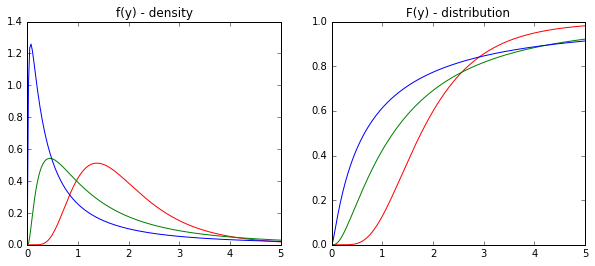

In [3]:
# Code to plot lognormal densities & distributions with a variety of parameters

##########################################
plt.rcParams["figure.figsize"] = (10,4)
fig, ax = plt.subplots(1, 2)
##########################################

from scipy.stats import lognorm

x = np.linspace(0, 5, 200)

# mean is e^{mu + sigma^2/2}
mean = 2
dists = [
    lognorm(0.5, 0, np.exp(np.log(mean) - 0.5**2/2)), # sigma = 0.5, mean = 2
    lognorm(1.0, 0, np.exp(np.log(mean) - 1.0**2/2)), # sigma = 1.0, mean = 2
    lognorm(1.5, 0, np.exp(np.log(mean) - 1.5**2/2))  # sigma = 1.5, mean = 2
]

for dist, color in zip(dists, colors):
    ax[0].plot(x, dist.pdf(x),color)
    ax[1].plot(x, dist.cdf(x),color)
    
ax[0].set_title("f(y) - density")
ax[1].set_title("F(y) - distribution");


### Constructing Lorenz curves (theory)

Observe that either the density or the (cumulative) distribution function completely describes a probability distribution. A Lorenz curve is another way to describe a probability distribution, up to a scale factor. For each $p$, $L(p)$ is the fraction of total income earned by the poorest $p$ fraction of the population. More formally

$$L(p) = \frac{\int_{0}^{p} Q(z)\,dz}{\int_{0}^{1} Q(z)\,dz} = \frac{\int_{0}^{Q(p)} y f(y)\,dy}{\mathsf{E}(y)}$$

where we define the (generalized) inverse c.d.f., the quantile function,

$$Q(z) = F^{-1}(z) = \mathrm{inf} \{ x: F(x) \geq z \}$$,

and note that $\int_{0}^{p} Q(z)\,dz = \int_{0}^{Q(p)} y f(y)\,dy.$ This is the partial mean up to $Q(p)$, which equals the mean income, $\mathsf{E}(y)$, when $p = 1$.

Since $L(p)$ is a constant times the integral of an increasing function $Q(\cdot)$, it is increasing and convex.

The Lorenz curves for the lognormal distributions shown above look like this:

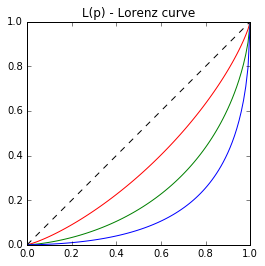

In [4]:
# Code to plot lorenz curves for the distributions above

##########################################
plt.rcParams["figure.figsize"] = (4,4)
##########################################

from scipy.integrate import quad

x = np.linspace(0, 1, 100)

def make_lorenz(dist):
    return np.vectorize(lambda p:
        quad(lambda y: y * dist.pdf(y), a = 0, b = dist.ppf(p))[0] / dist.stats()[0]
    )
    
for dist, color in zip(dists,colors):
    plt.plot(x, make_lorenz(dist)(x),color)

# Plot the 45 degree line (total equality)
plt.ylim(0,1)
plt.plot(x,x,"k--")

plt.title("L(p) - Lorenz curve");

A few properties of lognormal Lorenz curves are visible on this chart. The dashed 45 degree line represents perfect equality: the first 10% of the population earns 10% of the income, etc. The further a Lorenz curve is from that line, the higher the inequality (by this measure).

The blue line, which is for the distribution with the highest variance ($\sigma^2$) parameter, also has the highest inequality. And all the Lorenz curves are symmetric about the anti-diagonal (not plotted).

### Deriving the c.d.f from the Lorenz curve

It follows that given $L(p)$ we can derive the quantile function (inverse c.d.f) as

$$Q(p) = \mathsf{E}(y) \cdot L'(p)$$

where $L'(p) = \frac{d}{dp} L(p)$.

Since the support of a distribution is given by $[Q(0), Q(1)]$, we can observe that the derivatives at either endpoint of the Lorenz curve dictate the minimum and maximum values of the distribution. The Lorenz curve for a distribution with support on the entire real line (minimum income 0, maximum $\to \infty$) must then have a derivative of 0 at 0 and $\infty$ in the limit as it goes to 1. This is the case for the lognormal distribution, and - although it's not obvious from the plot above - we can see this to be the case if we zoom in a bit.

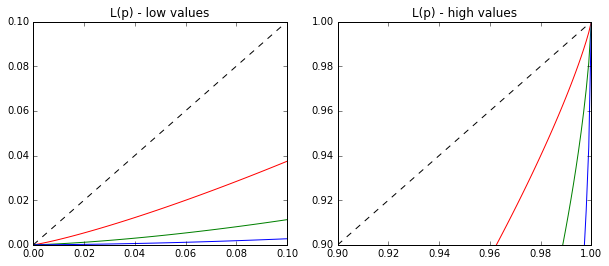

In [5]:
# Code to zoom in on the low and high endpoints of the Lorenz curves above

##########################################
plt.rcParams["figure.figsize"] = (10,4)
fig, ax = plt.subplots(1, 2)
ax[0].set_xlim((0.0, 0.1))
ax[0].set_ylim((0.0, 0.1))
ax[1].set_xlim((0.9, 1.0))
ax[1].set_ylim((0.9, 1.0))
##########################################

x0 = np.linspace(0, 0.1, 100)
x1 = np.linspace(0.9, 1.0, 100)
for dist, color in zip(dists,colors):
    lorenz = make_lorenz(dist)
    ax[0].plot(x0, lorenz(x0),color)
    ax[1].plot(x1, lorenz(x1),color)

ax[0].plot(x0,x0,"k--")
ax[1].plot(x1,x1,"k--")

ax[0].set_title("L(p) - low values")
ax[1].set_title("L(p) - high values");

### Constructing Lorenz curves from data

Recall from the introduction that a Lorenz curve has an obvious empirical analogue, which we constructed as part of our grouped data. We can review it here:

In [6]:
# Code to output just the p and L columns from the grouped data
stats[['$p$', 'cum_Y_p ($L$)']]

,$p$,cum_Y_p ($L$)
0,0.1,0.03
1,0.5,0.29
2,0.7,0.48
3,0.9,0.76
4,1.0,1.00


It follows from the definition that $L(0) = 0$ and $L(1) = 1$. By construction the former is implicit here, while the latter is included in the table. (PovcalNet constructs and outputs Lorenz tables in the same way.) We can plot the points, and it should be clear that the curve is increasing and convex as required.

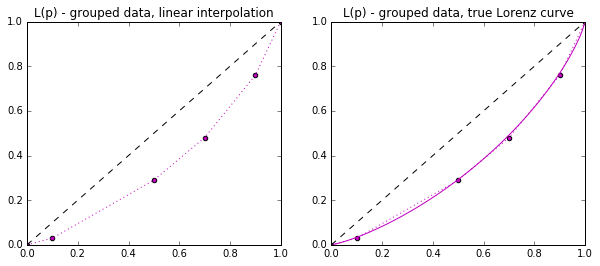

In [7]:
# Code to plot lorenz curves for the grouped data

##########################################
plt.rcParams["figure.figsize"] = (10,4)
fig, ax = plt.subplots(1, 2)
##########################################

p = [0.0] + stats['$p$'].tolist()
L = [0.0] + stats['cum_Y_p ($L$)'].tolist()

x = np.linspace(0, 1, 100)

ax[0].set_xlim(0, 1)
ax[0].set_ylim(0, 1)
ax[0].scatter(p, L, c="m")
ax[0].plot(p, L, "m:")

# Plot the 45 degree line (total equality)
ax[0].plot(x,x,"k--")

ax[0].set_title("L(p) - grouped data, linear interpolation");

ax[1].set_xlim(0, 1)
ax[1].set_ylim(0, 1)
ax[1].scatter(p, L, c="m")
ax[1].plot(p, L, "m:")
ax[1].plot(x, dist_example.lorenz(x), "m")

# Plot the 45 degree line (total equality)
ax[1].plot(x,x,"k--")

ax[1].set_title("L(p) - grouped data, true Lorenz curve");

Since we only observe a finite number of Lorenz curve points, we do not normally know the 'true' shape of curve. On the left, we show a very natural interpolation - piecewise linear. On the right, we also show the 'true' Lorenz curve generated directly by the distribution from which we originally drew the sample.

The piecewise linear interpolation may be adequate for some purposes: for example, even with a small number of points, the Gini index so calculated will be quite accurate. However, comparing it with the curve at the right, we can see there are two sources of error:

- sampling error: some of the points do not lie exactly on the true line, because they are statistics of a finite sample
- interpolation error: in this case, the true line curves smoothly, and so sometimes deviates from the linear interpolation

There is an additional issue, which though technical is aesthetically quite important. Recall from the theory section that the quantile function (and hence its inverse, the c.d.f) depends on the derivative of the Lorenz curve. A piecewise linear function has a piecewise constant derivative, so the c.d.f. will be a discontinuous step function. Such a c.d.f. has no p.d.f, but instead has a probability mass function (p.m.f.) as it describes a discrete probability distribution. In this case, the p.m.f. will have atoms of mass equal to the entries in the Lorenz table, above.

This rendering of the Lorenz data is unlikely to reflect the true income distribution, which for a large population - while technically still discrete - would be better represented as a continuous distribution, with the atoms smoothed out over the support of the distribution.

This issue motivates the next chapter, which investigates various better methods of interpolating the grouped data. They are further illustrated in Appendix A.